In [2]:
# 去看看要import的東西並且不要一次全部import
import torch
import cv2
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Simple_DE') # this path is the path of the current .ipynb
import numpy as np
import shutil
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math
from PIL import Image
import torch.nn as nn
import yaml
import random
from google.colab import files
import sys
import time
from torch.utils.data import random_split
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu" # 檢查是否有可用的 CUDA 設備（通常是顯卡，支援 GPU 運算），如果有，就將 device 變數設置為 "cuda"，否則設置為 "cpu"。

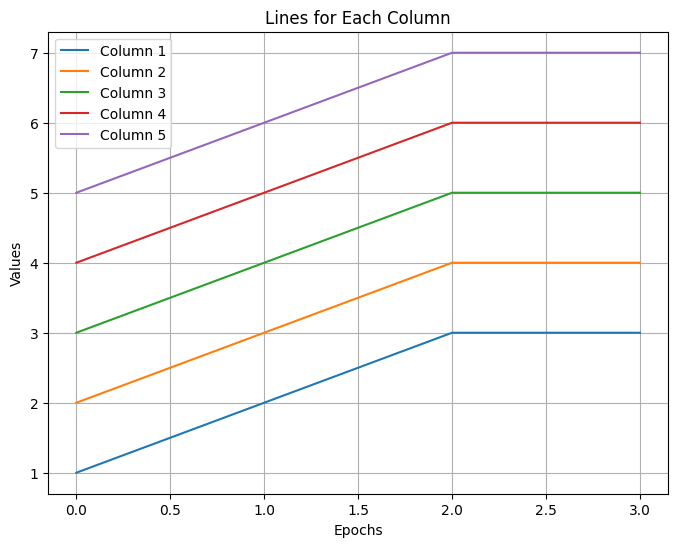

In [ ]:


data = [
    [1, 2, 3, 4, 5],
    [2, 3, 4, 5, 6],
    [3, 4, 5, 6, 7],
    [3, 4, 5, 6, 7]
]

# 绘制每列的线
plt.figure(figsize=(8, 6))  # 设置图形大小
for col in range(len(data[0])):
    column_data = []
    for row in data:
        column_data.append(row[col])
    plt.plot(column_data, label=f'Column {col+1}')

plt.xlabel('Epochs')  # 设置 x 轴标签
plt.ylabel('Values')  # 设置 y 轴标签
plt.title('Lines for Each Column')  # 设置标题
plt.legend()  # 添加图例
plt.grid(True)  # 添加网格线
plt.show()  # 显示图形

In [4]:
path = 'Model/config/depth_analysis.pth' # 讀取depth的統計數字
# path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Model/config/depth_analysis.pth'

check = torch.load(path)
total_sum = check['total_sum']
DEPTH_NONZERO = check['total_nonzero']
DEPTH_MEAN = check['total_mean']
DEPTH_STD = check['total_std']
del check

In [5]:
from Model.functions.functions import load_config
file_path = 'Model/config/config.yml'
# file_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Model/config/config.yml'
config = load_config(file_path)

In [6]:
target_size = (config['data']['image_size'], config['data']['image_size'])

In [7]:
from Model.Model1.model1_script import Model

model = Model(config)
model = model.to(device)

In [8]:
# BATCH_SIZE = 256

NO_LARGE_EPOCHS = 10
save_frequency = 5
LR = 0.001
VERBOSE = False
# data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'
# name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip_shuffle'
name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip_shuffle'
batch_size = 32
train_val_rate = 0.99
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [9]:
from Model.Data_Process.data_processing import create_dataset_large_epoch, CustomDataset, image_loader_to_tensor, depth_loader_to_tensor

In [10]:
class Model_optimize:
    def __init__(self, model, weight_path, loaded = False):
        if loaded == False:
            checkpoint = torch.load(weight_path, map_location=torch.device(device))
            model.load_state_dict(checkpoint['model_state_dict'])
        self.model = model
        count = 0
        for name, param in model.named_parameters():
            count += 1
        self.amount_of_param = count
    def find_a_parameter(self, target):
        list = []

        for name, param in model.named_parameters():
            par_shape = len(param.shape)
            if par_shape == 1:
                if param[0] == target:
                    list.append(name)
            elif par_shape == 2:
                if param[0][0] == target:
                    list.append(name)
            elif par_shape == 3:
                if param[0][0][0] == target:
                    list.append(name)
            elif par_shape == 4:
                if param[0][0][0][0] == target:
                    list.append(name)
        return list
    def analyst_param(self):
        for name, param in model.named_parameters():
            print('{} | {}'.format(name, param))
            print('--------------------------')
    def list_name(self):
        for name, param in model.named_parameters():
            print(name)
            print('--------------------------')
    def statics(self):
        for name, param in model.named_parameters():
            print('{} | max = {} | min = {} | mean = {}'.format(name, torch.max(param), torch.min(param), torch.mean(param)))
    def plot_name(self, name):
        for names, param in model.named_parameters():
            if names == name:
                weights_list = param.data.cpu().numpy().flatten()
                plt.figure(figsize=(7, 5))
                plt.title('Weight Distribution')
                plt.hist(weights_list, bins=50, alpha=0.7)
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.show()

                break
    def plot_idx(self, idx):
        count = 0
        for names, param in model.named_parameters():
            if count == idx:
                weights_list = param.data.cpu().numpy().flatten()
                plt.figure(figsize=(7, 5))
                plt.title(names)
                plt.hist(weights_list, bins=50, alpha=0.7)
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.show()

                break
            count += 1
    def plot_whole_sep(self):
        for idx in range(self.amount_of_param):
            self.plot_idx(idx)

    def plot_whole(self):
        weights_list = []
        for name, param in model.named_parameters():
            weights_list.append(param.data.cpu().numpy().flatten())
        plt.figure(figsize=(7, 5))
        plt.title('whole_plot')
        plt.hist(weights_list, bins=50, alpha=0.7)
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.show()

In [11]:
# weight_path1 = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/fpn_changed_debug_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
# checkpoint = torch.load(weight_path1, map_location=torch.device(device))

In [12]:
# checkpoint['gradients'].keys()

In [13]:
class Model_optimize_comp:
    def __init__(self, Model, config, weight_path1, weight_path2, loaded = False):
        if loaded == False:
            checkpoint = torch.load(weight_path1, map_location=torch.device(device))
            self.grad1 = checkpoint['gradients']
            model = Model(config)
            model.load_state_dict(checkpoint['model_state_dict'])
            self.model1 = model
            del model
            model = Model(config)
            checkpoint = torch.load(weight_path2, map_location=torch.device(device))
            self.grad2 = checkpoint['gradients']
            model.load_state_dict(checkpoint['model_state_dict'])
            self.model2 = model

        count = 0
        for name, param in self.model1.named_parameters():
            count += 1
        self.amount_of_param = count
    def list_name(self):
        for name, param in self.model1.named_parameters():
            print(name)
            print('--------------------------')
    def statics(self):
        for name, param in self.model1.named_parameters():
            for name2, param2 in self.model2.named_parameters():
                if name2 == name:
                    break
            print('{} | max = {} | min = {} | mean = {}'.format(name, torch.max(param), torch.min(param), torch.mean(param)))
            print('{} | max = {} | min = {} | mean = {}'.format(name, torch.max(param2), torch.min(param2), torch.mean(param2)))
    def plot_name(self, name):
        for names, param in self.model1.named_parameters():
            if names == name:
                weights_list = param.data.cpu().numpy().flatten()
                plt.figure(figsize=(7, 5))
                plt.title('Weight Distribution')
                plt.hist(weights_list, bins=50, alpha=0.7)
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.show()

                break
    def plot_idx(self, idx):
        count = 0
        for names, param in self.model1.named_parameters():
            for names2, param2 in self.model2.named_parameters():
                if names2 == names:
                    break
            if count == idx:
                weights_list1 = param.data.cpu().numpy().flatten()
                weights_list2 = param2.data.cpu().numpy().flatten()

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title(names)
                mini = torch.min(weights_list1)
                maxi = torch.max(weights_list1)
                plt.xlim(mini, maxi)
                plt.hist(weights_list1, bins=50, alpha=0.7)
                plt.subplot(1, 2, 2)
                plt.title(names)
                plt.xlim(mini, maxi)
                plt.hist(weights_list2, bins=50, alpha=0.7)
                plt.show()

                break
            count += 1
    def plot_whole_sep(self):
        for idx in range(self.amount_of_param):
            self.plot_idx(idx)

    def ana_comp(self):
        for names, param in self.model1.named_parameters():
            for names2, param2 in self.model2.named_parameters():
                if names2 == names:
                    break
            max_ratio = torch.max(param) / torch.max(param2)
            min_ratio = torch.min(param) / torch.min(param2)
            mean_ratio = torch.mean(param) / torch.mean(param2)
            std_ratio = torch.std(param) / torch.std(param2)
            print('name = {} | max ratio = {} | min ratio = {} | mean ratio = {} | std ratio = {}'.format(names, max_ratio, min_ratio, mean_ratio, std_ratio))
    def grad_comp(self):
        for keys in self.grad1:
            max_ratio = torch.max(self.grad1[keys]) / torch.max(self.grad2[keys])
            min_ratio = torch.min(self.grad1[keys]) / torch.min(self.grad2[keys])
            mean_ratio = torch.mean(self.grad1[keys]) / torch.mean(self.grad2[keys])
            std_ratio = torch.std(self.grad1[keys]) / torch.std(self.grad2[keys])
            print('name = {} | max ratio = {} | min ratio = {} | mean ratio = {} | std ratio = {}'.format(keys, max_ratio, min_ratio, mean_ratio, std_ratio))


    def print_grad(self):
        for keys, values in self.grad2.items():
            print('{} : {}'.format(keys, values))
    def show_count(self):
        print(self.amount_of_param)

In [14]:
count = 0
path_list = []
for large_epoch in range(1, 4):

    while True:
        count += 1
        path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_{}_{}.pth'.format(large_epoch, count)
        path_list.append(path)
        if count % 18 == 0:
            break

path_list

['/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_1.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_2.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_3.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_4.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_5.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_6.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_7.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_8.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_9.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_1_10.pth',
 '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoi

In [46]:
len(path_list)

54

In [42]:
class plot:
    def __init__(self, path_list):
        self.path_list = path_list
        # checkpoint = torch.load(path, map_location=torch.device(device))
        # self.grad1 = checkpoint['gradients']
        # model = Model(config)
        # model.load_state_dict(checkpoint['model_state_dict'])
        # self.model1 = model
        # self.path_list = path_list
        # del model
        # model = Model(config)
        # # checkpoint = torch.load(weight_path2, map_location=torch.device(device))
        # self.grad2 = checkpoint['gradients']
        # model.load_state_dict(checkpoint['model_state_dict'])
        # self.model2 = model

        # count = 0
        # for name, param in self.model1.named_parameters():
        #     count += 1
        # self.amount_of_param = count
    def draw_grad(self, epoch_interval, param_interval, legend = True):
        output_list = [] # row代表不同的epochs column代表不同的params
        keys_list = []
        count = 0
        x_coor = []
        for idx in range(epoch_interval[0], epoch_interval[1]):
            x_coor.append(idx)
            file = self.path_list[idx] # traverse epoch
            tmp_list = []
            check = torch.load(file, map_location = torch.device(device))
            grad = check['gradients']
            if count == 0:
                count += 1
                keys_list = list(grad.keys())
                keys_list = keys_list[param_interval[0] : param_interval[1]]
            for key in keys_list:
                summ = torch.mean(torch.abs(grad[key]))
                tmp_list.append(summ)
            output_list.append(tmp_list)
        plt.figure(figsize=(8, 6))  # 设置图形大小
        for col in range(len(output_list[0])):
            column_data = []
            for row in output_list:
                column_data.append(row[col])
            plt.plot(x_coor, column_data, label=keys_list[col])

        plt.xlabel('Epochs')  # 设置 x 轴标签
        plt.ylabel('Values')  # 设置 y 轴标签
        plt.title('Lines for Each Column')  # 设置标题
        if legend:
            plt.legend()  # 添加图例
        plt.grid(True)  # 添加网格线
        plt.show()  # 显示图形
    def count_param(self):
        file = self.path_list[0]
        check = torch.load(file, map_location = torch.device(device))
        grad = check['gradients']
        keys_list = list(grad.keys())
        print("there are {} many gradients groups".format(len(keys_list)))





In [47]:
plotting = plot(path_list)
epoch_interval = [1, 20]
for idx in range(50):
    param_interval = [idx * 10, (idx + 1) * 10]
    plotting.draw_grad(epoch_interval, param_interval, legend = False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plotting = plot(path_list)
epoch_interval = [20, 50]
for idx in range(50):
    param_interval = [idx * 10, (idx + 1) * 10]
    plotting.draw_grad(epoch_interval, param_interval, legend = False)

In [45]:
plotting.count_param()

there are 508 many gradients groups


In [22]:
file = path_list[0] # traverse epoch
tmp_list = []
check = torch.load(file, map_location = torch.device(device))
grad = check['gradients']

In [24]:
keys_list = grad.keys()

In [32]:
test = list(keys_list)
type(test[0])

str

In [ ]:
large_epoch = 1
epoch = 5
# load_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model0_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
load_path1 = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/fpn_changed_debug_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
# check = torch.load(load_path, map_location = torch.device(device))

In [ ]:
large_epoch = 2
epoch = 25
# load_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model0_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
load_path2 = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/fpn_changed_debug_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
# check = torch.load(load_path, map_location = torch.device(device))

In [ ]:
opt = Model_optimize_comp(Model, config, load_path1, load_path2)


In [ ]:
opt.print_grad()

串流輸出內容已截斷至最後 5000 行。
         5.9458e-13, -4.3054e-14,  4.7148e-13,  1.0352e-12, -2.4291e-13,
         1.6988e-12, -1.3833e-12,  6.4172e-13, -3.9708e-13, -5.5928e-13,
        -2.8781e-13,  8.1598e-13,  1.0728e-12,  1.1930e-12, -1.1521e-12,
        -1.2571e-12,  1.7691e-12, -2.1620e-12,  1.4684e-12,  6.9607e-13,
         9.3064e-13,  1.3660e-12, -9.4350e-13, -2.2807e-13,  1.6307e-13,
        -8.3241e-13, -7.2260e-13, -5.9460e-13, -5.4713e-13,  5.5131e-13,
         5.6750e-13,  1.2311e-13, -5.4932e-14,  4.3523e-13,  2.4748e-14,
         8.4728e-14, -3.0034e-13, -1.7627e-12,  1.8653e-13, -7.4024e-13,
        -1.3427e-12,  4.4627e-13,  8.3407e-14, -6.3006e-14,  7.3593e-13,
        -1.5453e-12,  1.8434e-12,  2.7010e-14,  5.4448e-13,  2.6682e-13,
        -7.0325e-13,  3.3019e-14,  3.0906e-13, -1.3721e-13,  3.6782e-13,
        -5.1032e-14,  8.8983e-14,  2.8727e-13,  6.0487e-13, -9.5857e-13,
        -3.8160e-13,  1.7514e-13, -2.0155e-13, -1.1847e-12,  7.0742e-13,
        -1.5514e-12,  5.2436e-

In [ ]:
opt.grad_comp()

In [ ]:
opt.ana_comp()

name = fpn.ConvList.0.conv.weight | max ratio = 0.823091447353363 | min ratio = 0.8796905279159546 | mean ratio = 1.122298240661621 | std ratio = 0.9744706153869629
name = fpn.ConvList.0.conv.bias | max ratio = 0.9841118454933167 | min ratio = 0.7614861726760864 | mean ratio = -11.374919891357422 | std ratio = 0.9095815420150757
name = fpn.ConvList.1.conv.weight | max ratio = 0.4148251414299011 | min ratio = 0.48927319049835205 | mean ratio = -1.1650441884994507 | std ratio = 0.8496768474578857
name = fpn.ConvList.1.conv.bias | max ratio = 0.549933910369873 | min ratio = 0.6016831994056702 | mean ratio = 0.285513699054718 | std ratio = 0.7276543974876404
name = fpn.ConvList.2.conv.weight | max ratio = 0.4004679024219513 | min ratio = 0.3703286647796631 | mean ratio = 0.445272296667099 | std ratio = 0.8049055337905884
name = fpn.ConvList.2.conv.bias | max ratio = 0.7250058054924011 | min ratio = 0.7294487357139587 | mean ratio = -0.13402004539966583 | std ratio = 0.7997837066650391
name

<ipython-input-43-a17c1ea45dfc>:80: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  std_ratio = torch.std(param) / torch.std(param2)


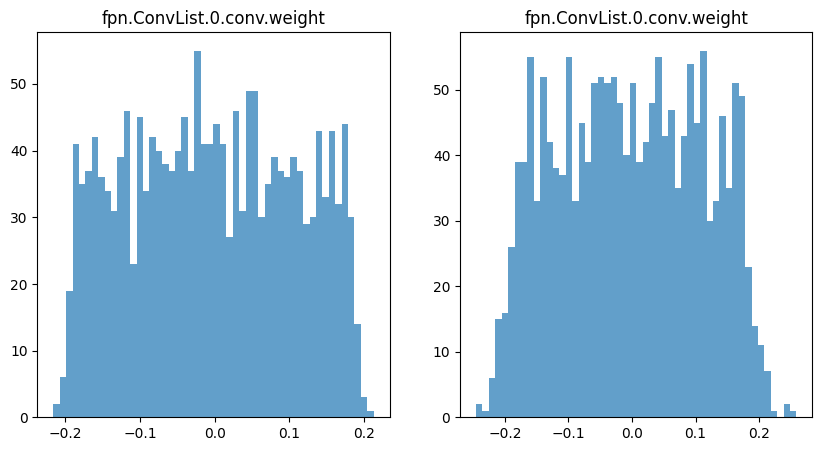

KeyboardInterrupt: 

In [ ]:
opt.plot_whole_sep()

In [ ]:
check.keys()

dict_keys(['large_epoch', 'epoch', 'model_state_dict', 'optimizer_state_dict', 'valid_loss', 'loss', 'now', 'random_list', 'gradients'])

In [ ]:
opt = Model_optimize(model, load_path)
# opt2 = Model_optimize(model, load_path2)

In [ ]:
opt.statics()

fpn.ConvList.0.conv.weight | max = 0.21277667582035065 | min = -0.21580857038497925 | mean = -0.0039374371990561485
fpn.ConvList.0.conv.bias | max = 0.2063370645046234 | min = -0.18427716195583344 | mean = 0.021503809839487076
fpn.ConvList.1.conv.weight | max = 0.10471604764461517 | min = -0.0907103419303894 | mean = 0.000478258152725175
fpn.ConvList.1.conv.bias | max = 0.05246509611606598 | min = -0.05302342027425766 | mean = 0.0031354837119579315
fpn.ConvList.2.conv.weight | max = 0.11118927597999573 | min = -0.0852760523557663 | mean = -0.00025803910102695227
fpn.ConvList.2.conv.bias | max = 0.04156789183616638 | min = -0.03731406480073929 | mean = -0.00034493982093408704
fpn.ConvList.3.conv.weight | max = 0.11793576180934906 | min = -0.12094998359680176 | mean = 1.5145215911616106e-05
fpn.ConvList.3.conv.bias | max = 0.029001375660300255 | min = -0.027162374928593636 | mean = -0.00020397061598487198
fpn.tuneChannels.0.weight | max = 0.07991432398557663 | min = -0.08292025327682495 

In [ ]:
opt.plot_whole_sep()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

#debug epoch

epoch = 0
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'
name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'
check_length = len(sorted(os.listdir(data_path)))
random_list = []
for idx in range(check_length):
    random_list.append(idx)
now = 15
output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
custom_dataset = CustomDataset(output_image, output_depth)
train_size = int(train_val_rate * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
for large_epoch in range(1, NO_LARGE_EPOCHS + 1):



    for now in range(check_length): # 一個小epoch是一個checkpoint檔，紀錄一次

        epoch += 1


        # output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
        # custom_dataset = CustomDataset(output_image, output_depth)
        # train_size = int(train_val_rate * len(custom_dataset))
        # val_size = len(custom_dataset) - train_size
        # train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
        # trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
        # validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
        start_time = time.time()
        mean_epoch_loss = []
        mean_epoch_loss_val = []
        epoch_gradient = {}
        for batch in trainloader:
            t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

            input_img = batch['img'].to(torch.float32).to(device)
            input_img = image_loader_to_tensor(input_img)
            target_depth = batch['depth'].to(torch.float32).to(device)
            target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

            pred_depth = model(input_img, target_depth, t)

            optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
            mean_epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            #---gradient---vvv
            for name, param in model.named_parameters():
                if param.grad == None:
                    epoch_gradient[name + 'zero'] = 1
                elif name not in epoch_gradient:
                    epoch_gradient[name] = param.grad.clone()
                else:
                    epoch_gradient[name] += param.grad
            #---gradient---^^^
        with torch.inference_mode():
            for batch in validloader:
                t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
                input_img = batch['img'].to(torch.float32).to(device)

                input_img = image_loader_to_tensor(input_img)
                target_depth = batch['depth'].to(torch.float32).to(device)
                target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)
                pred_depth = model(input_img, target_depth, t)

                val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
                mean_epoch_loss_val.append(val_loss.item())

        if epoch % save_frequency == 0 or epoch == check_length * NO_LARGE_EPOCHS:
            checkpoint = {
                'large_epoch' : large_epoch,
                'epoch': epoch,
                'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
                'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
                'valid_loss' : np.mean(mean_epoch_loss_val),
                'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
                'now' : now,
                'random_list' : random_list,
                'gradients' : epoch_gradient
            }

            torch.save(checkpoint, 'weight_{}_{}.pth'.format(large_epoch, epoch))
            source_path = 'weight_{}_{}.pth'.format(large_epoch, epoch)
            destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model0_weight'
            # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_weight'


            # save them to the google drive
            shutil.copy(source_path, destination_path)

        #---計算時間---vvv
        end_time = time.time()
        exe_time = end_time - start_time
        hours, remainder = divmod(exe_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        #---計算時間---^^^

        #-----以下是存loss的---vvv
        checkpoint = {
        'large_epoch' : large_epoch,
        'epoch': epoch,
        'valid_loss' : np.mean(mean_epoch_loss_val),
        'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
        'time' : exe_time
        }

        torch.save(checkpoint, 'loss_{}_{}.pth'.format(large_epoch, epoch))
        source_path = 'loss_{}_{}.pth'.format(large_epoch, epoch)
        # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_loss'
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model0_loss'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^

        print('---')
        print(f"Large Epoch: {large_epoch}, Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        print("time = {}:{}:{}".format(int(hours), int(minutes), int(seconds)))


---
Large Epoch: 1, Epoch: 1 | Train Loss 0.3138700756546739 | Val Loss 0.2498665750026703
time = 0:0:55
---
Large Epoch: 1, Epoch: 2 | Train Loss 0.2670277159709435 | Val Loss 0.24605220556259155
time = 0:0:50
---
Large Epoch: 1, Epoch: 3 | Train Loss 0.2628909808087659 | Val Loss 0.20956990122795105
time = 0:0:50
---
Large Epoch: 1, Epoch: 4 | Train Loss 0.2606025631358097 | Val Loss 0.24030309915542603
time = 0:0:50
---
Large Epoch: 1, Epoch: 5 | Train Loss 0.25821096991950815 | Val Loss 0.25779250264167786
time = 0:1:12
---
Large Epoch: 1, Epoch: 6 | Train Loss 0.2564492982316327 | Val Loss 0.2746621072292328
time = 0:0:53
---
Large Epoch: 1, Epoch: 7 | Train Loss 0.25458256697112863 | Val Loss 0.2304874211549759
time = 0:0:50
---
Large Epoch: 1, Epoch: 8 | Train Loss 0.25352608644730085 | Val Loss 0.20992034673690796
time = 0:0:50
---
Large Epoch: 1, Epoch: 9 | Train Loss 0.2489579738928126 | Val Loss 0.24297675490379333
time = 0:0:50
---
Large Epoch: 1, Epoch: 10 | Train Loss 0.2

KeyboardInterrupt: 

In [ ]:
'''
# continue training debug
large_epoch = 1
epoch = 10
# load_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
# data_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip_shuffle'
load_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model0_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip_shuffle'
check_length = len(sorted(os.listdir(data_path)))
checkpoint = torch.load(load_path, map_location=torch.device(device))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'
name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'
check_length = len(sorted(os.listdir(data_path)))
random_list = []
for idx in range(check_length):
    random_list.append(idx)
now = 15
output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
custom_dataset = CustomDataset(output_image, output_depth)
train_size = int(train_val_rate * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


for now in range(epoch, 51): # 一個小epoch是一個checkpoint檔，紀錄一次

    epoch += 1
    start_time = time.time()
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    epoch_gradient = {}
    for batch in trainloader:
        t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

        input_img = batch['img'].to(torch.float32).to(device)
        target_depth = batch['depth'].to(torch.float32).to(device)

        input_img = image_loader_to_tensor(input_img)
        target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

        pred_depth = model(input_img, target_depth, t)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        #---gradient---vvv
            for name, param in model.named_parameters():
                if param.grad == None:
                    epoch_gradient[name + 'zero'] = 1
                elif name not in epoch_gradient:
                    epoch_gradient[name] = param.grad.clone()
                else:
                    epoch_gradient[name] += param.grad
            #---gradient---^^^
    with torch.inference_mode():
        for batch in validloader:
            t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
            input_img = batch['img'].to(torch.float32).to(device)
            target_depth = batch['depth'].to(torch.float32).to(device)
            input_img = image_loader_to_tensor(input_img)
            target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)
            pred_depth = model(input_img, target_depth, t)

            val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
            mean_epoch_loss_val.append(val_loss.item())

    if epoch % save_frequency == 0 or epoch == check_length * NO_LARGE_EPOCHS:
        checkpoint = {
            'large_epoch' : large_epoch,
            'epoch': epoch,
            'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
            'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
            'valid_loss' : np.mean(mean_epoch_loss_val),
            'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
            'now' : now,
            'random_list' : random_list,
            'gradients' : epoch_gradient
        }

        torch.save(checkpoint, 'weight_{}_{}.pth'.format(large_epoch, epoch))
        source_path = 'weight_{}_{}.pth'.format(large_epoch, epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_weight'


        # save them to the google drive
        shutil.copy(source_path, destination_path)

        #---計算時間---vvv
        end_time = time.time()
        exe_time = end_time - start_time
        hours, remainder = divmod(exe_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        #---計算時間---^^^

        #-----以下是存loss的---vvv
        checkpoint = {
        'large_epoch' : large_epoch,
        'epoch': epoch,
        'valid_loss' : np.mean(mean_epoch_loss_val),
        'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
        'time' : exe_time
        }

        torch.save(checkpoint, 'loss_{}_{}.pth'.format(large_epoch, epoch))
        source_path = 'loss_{}_{}.pth'.format(large_epoch, epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_loss'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^

    print('---')
    print(f"Large Epoch: {large_epoch}, Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
    print("time = {}:{}:{}".format(hours, minutes, seconds))

'''


'\n# continue training debug\nlarge_epoch = 1\nepoch = 10\n# load_path = \'/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_weight/weight_{}_{}.pth\'.format(large_epoch, epoch)\n# data_path = \'/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip_shuffle\'\nload_path = \'/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model0_weight/weight_{}_{}.pth\'.format(large_epoch, epoch)\ndata_path = \'/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip_shuffle\'\ncheck_length = len(sorted(os.listdir(data_path)))\ncheckpoint = torch.load(load_path, map_location=torch.device(device))\n\nmodel.load_state_dict(checkpoint[\'model_state_dict\'])\noptimizer.load_state_dict(checkpoint[\'optimizer_state_dict\'])\n\n\n\ndata_path = \'/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip\'\nname_path = \'/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip\'\ncheck_length = len(sorted(os.listdir(data_path)))\nrandom_list = []\nfo

In [ ]:



# first epoch
epoch = 0
# data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'
# name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'
check_length = len(sorted(os.listdir(data_path)))
for large_epoch in range(1, NO_LARGE_EPOCHS + 1):

    random_list = []

    for idx in range(check_length):
        random_list.append(idx)

    random.shuffle(random_list)

    for now in range(check_length): # 一個小epoch是一個checkpoint檔，紀錄一次

        epoch += 1
        output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
        custom_dataset = CustomDataset(output_image, output_depth)
        train_size = int(train_val_rate * len(custom_dataset))
        val_size = len(custom_dataset) - train_size
        train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
        trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
        validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
        start_time = time.time()
        mean_epoch_loss = []
        mean_epoch_loss_val = []
        epoch_gradient = {}
        for batch in trainloader:
            t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

            input_img = batch['img'].to(torch.float32).to(device)
            input_img = image_loader_to_tensor(input_img)
            target_depth = batch['depth'].to(torch.float32).to(device)
            target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

            pred_depth = model(input_img, target_depth, t)

            optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
            mean_epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            #---gradient---vvv
            for name, param in model.named_parameters():
                if param.grad == None:
                    epoch_gradient[name + 'zero'] = 1
                elif name not in epoch_gradient:
                    epoch_gradient[name] = param.grad.clone()
                else:
                    epoch_gradient[name] += param.grad
            #---gradient---^^^
        with torch.inference_mode():
            for batch in validloader:
                t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
                input_img = batch['img'].to(torch.float32).to(device)

                input_img = image_loader_to_tensor(input_img)
                target_depth = batch['depth'].to(torch.float32).to(device)
                target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)
                pred_depth = model(input_img, target_depth, t)

                val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
                mean_epoch_loss_val.append(val_loss.item())

        if epoch % save_frequency == 0 or epoch == check_length * NO_LARGE_EPOCHS:
            checkpoint = {
                'large_epoch' : large_epoch,
                'epoch': epoch,
                'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
                'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
                'valid_loss' : np.mean(mean_epoch_loss_val),
                'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
                'now' : now,
                'random_list' : random_list,
                'gradients' : epoch_gradient
            }

            torch.save(checkpoint, 'weight_{}_{}.pth'.format(large_epoch, epoch))
            source_path = 'weight_{}_{}.pth'.format(large_epoch, epoch)
            destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_weight'
            # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_weight'


            # save them to the google drive
            shutil.copy(source_path, destination_path)

        #---計算時間---vvv
        end_time = time.time()
        exe_time = end_time - start_time
        hours, remainder = divmod(exe_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        #---計算時間---^^^

        #-----以下是存loss的---vvv
        checkpoint = {
        'large_epoch' : large_epoch,
        'epoch': epoch,
        'valid_loss' : np.mean(mean_epoch_loss_val),
        'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
        'time' : exe_time
        }

        torch.save(checkpoint, 'loss_{}_{}.pth'.format(large_epoch, epoch))
        source_path = 'loss_{}_{}.pth'.format(large_epoch, epoch)
        # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_loss'
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_loss'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^

        print('---')
        print(f"Large Epoch: {large_epoch}, Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        print("time = {}:{}:{}".format(int(hours), int(minutes), int(seconds)))


---
Large Epoch: 1, Epoch: 1 | Train Loss 0.4699049001777327 | Val Loss 0.4157452881336212
time = 0:0:54
---
Large Epoch: 1, Epoch: 2 | Train Loss 0.4137105943707677 | Val Loss 0.36317160725593567
time = 0:0:53
---
Large Epoch: 1, Epoch: 3 | Train Loss 0.38594264953167406 | Val Loss 0.3341519236564636
time = 0:0:51
---
Large Epoch: 1, Epoch: 4 | Train Loss 0.3802777457159835 | Val Loss 0.38534772396087646
time = 0:0:51
---
Large Epoch: 1, Epoch: 5 | Train Loss 0.3720323845937655 | Val Loss 0.3812806010246277
time = 0:2:17
---
Large Epoch: 1, Epoch: 6 | Train Loss 0.3640818607497525 | Val Loss 0.3370104730129242
time = 0:0:52
---
Large Epoch: 1, Epoch: 7 | Train Loss 0.3555536792649851 | Val Loss 0.36060041189193726
time = 0:0:51
---
Large Epoch: 1, Epoch: 8 | Train Loss 0.35634204648531875 | Val Loss 0.3519660532474518
time = 0:0:51
---
Large Epoch: 1, Epoch: 9 | Train Loss 0.3490467506956744 | Val Loss 0.36629247665405273
time = 0:0:51
---
Large Epoch: 1, Epoch: 10 | Train Loss 0.3499

In [ ]:
# debug
large_epoch = 1
epoch = 8
# load_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
# data_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip_shuffle'
load_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip_shuffle'
check_length = len(sorted(os.listdir(data_path)))
checkpoint = torch.load(load_path, map_location=torch.device(device))

model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [ ]:
class Model_optimize:
    def __init__(self, model, weight_path, loaded = False):
        if loaded == False:
            checkpoint = torch.load(weight_path, map_location=torch.device(device))
            model.load_state_dict(checkpoint['model_state_dict'])
        self.model = model
        count = 0
        for name, param in model.named_parameters():
            count += 1
        self.amount_of_param = count
    def find_a_parameter(self, target):
        list = []

        for name, param in model.named_parameters():
            par_shape = len(param.shape)
            if par_shape == 1:
                if param[0] == target:
                    list.append(name)
            elif par_shape == 2:
                if param[0][0] == target:
                    list.append(name)
            elif par_shape == 3:
                if param[0][0][0] == target:
                    list.append(name)
            elif par_shape == 4:
                if param[0][0][0][0] == target:
                    list.append(name)
        return list
    def analyst_param(self):
        for name, param in model.named_parameters():
            print('{} | {}'.format(name, param))
            print('--------------------------')
    def list_name(self):
        for name, param in model.named_parameters():
            print(name)
            print('--------------------------')
    def statics(self):
        for name, param in model.named_parameters():
            print('{} | max = {} | min = {} | mean = {}'.format(name, torch.max(param), torch.min(param), torch.mean(param)))
    def plot_name(self, name):
        for names, param in model.named_parameters():
            if names == name:
                weights_list = param.data.cpu().numpy().flatten()
                plt.figure(figsize=(7, 5))
                plt.title('Weight Distribution')
                plt.hist(weights_list, bins=50, alpha=0.7)
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.show()

                break
    def plot_idx(self, idx):
        count = 0
        for names, param in model.named_parameters():
            if count == idx:
                weights_list = param.data.cpu().numpy().flatten()
                plt.figure(figsize=(7, 5))
                plt.title(names)
                plt.hist(weights_list, bins=50, alpha=0.7)
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.show()

                break
            count += 1
    def plot_whole_sep(self):
        for idx in range(self.amount_of_param):
            self.plot_idx(idx)

    def plot_whole(self):
        weights_list = []
        for name, param in model.named_parameters():
            weights_list.append(param.data.cpu().numpy().flatten())
        plt.figure(figsize=(7, 5))
        plt.title('whole_plot')
        plt.hist(weights_list, bins=50, alpha=0.7)
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.show()






In [ ]:
load_path = 'a'
opt = Model_optimize(model, load_path, loaded = True)

In [ ]:
opt.plot_whole_sep()

Output hidden; open in https://colab.research.google.com to view.

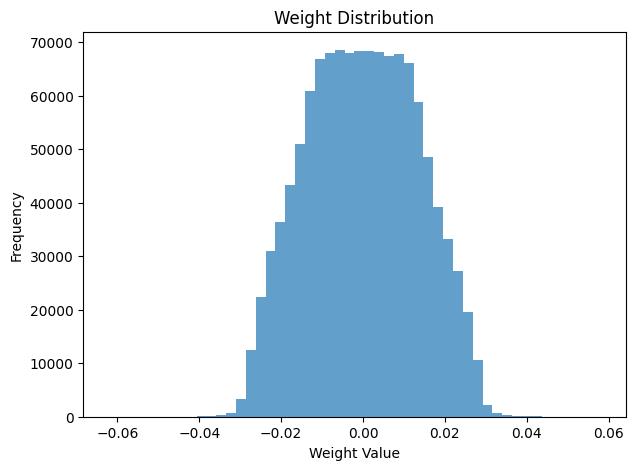

In [ ]:
idx = 6
opt.plot_idx(idx)

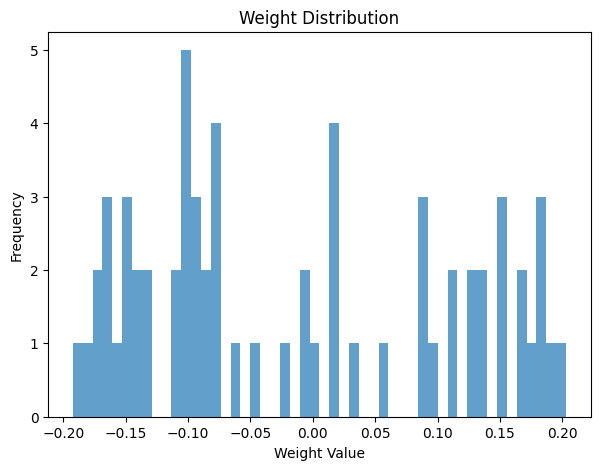

In [ ]:
name = 'fpn.ConvList.0.conv.bias'
opt.plot_name(name)

In [ ]:
opt.list_name()

fpn.ConvList.0.conv.weight
--------------------------
fpn.ConvList.0.conv.bias
--------------------------
fpn.ConvList.1.conv.weight
--------------------------
fpn.ConvList.1.conv.bias
--------------------------
fpn.ConvList.2.conv.weight
--------------------------
fpn.ConvList.2.conv.bias
--------------------------
fpn.ConvList.3.conv.weight
--------------------------
fpn.ConvList.3.conv.bias
--------------------------
fpn.tuneChannels.0.weight
--------------------------
fpn.tuneChannels.0.bias
--------------------------
fpn.tuneChannels.1.weight
--------------------------
fpn.tuneChannels.1.bias
--------------------------
fpn.tuneChannels.2.weight
--------------------------
fpn.tuneChannels.2.bias
--------------------------
fpn.tuneChannels.3.weight
--------------------------
fpn.tuneChannels.3.bias
--------------------------
fpn.Upsampple.0.conv.weight
--------------------------
fpn.Upsampple.0.conv.bias
--------------------------
fpn.Upsampple.1.conv.weight
------------------------

In [ ]:
count = 1
for name, param in model.named_parameters():
    if count == 2:
        print(param)
        break
    count += 1

Parameter containing:
tensor([ 0.0203,  0.0969, -0.0205, -0.0993,  0.1298, -0.1724, -0.1131,  0.2029,
         0.1817,  0.1706,  0.0143,  0.1313,  0.1516,  0.0882, -0.0005, -0.0800,
         0.1811, -0.0779, -0.1842,  0.1878, -0.1430,  0.1392, -0.0958, -0.0754,
        -0.1728,  0.0902, -0.1349,  0.1668, -0.0031, -0.1508, -0.0845,  0.0597,
         0.0298, -0.0983, -0.1676, -0.1124, -0.0848, -0.0905, -0.0998,  0.1145,
        -0.1924,  0.1537, -0.0784,  0.1796,  0.1742, -0.1468,  0.1087, -0.1624,
        -0.1487,  0.0208,  0.0190,  0.1519,  0.1383, -0.1370, -0.0105, -0.0949,
        -0.0588, -0.1414, -0.0981, -0.1564,  0.0863, -0.1632, -0.0439, -0.0984],
       requires_grad=True)


In [ ]:
load_path = 'a'
opt = Model_optimize(model, load_path, loaded = True)


In [ ]:
opt.statics()

fpn.ConvList.0.conv.weight | max = 0.19745191931724548 | min = -0.19767257571220398 | mean = -0.005037110298871994
fpn.ConvList.0.conv.bias | max = 0.20293505489826202 | min = -0.19235675036907196 | mean = -0.012554172426462173
fpn.ConvList.1.conv.weight | max = 0.07060471177101135 | min = -0.06894844025373459 | mean = -0.0008953078067861497
fpn.ConvList.1.conv.bias | max = 0.04677022993564606 | min = -0.04946092516183853 | mean = -0.0019499564077705145
fpn.ConvList.2.conv.weight | max = 0.06392478197813034 | min = -0.06878671050071716 | mean = -0.0004202147538308054
fpn.ConvList.2.conv.bias | max = 0.04184049740433693 | min = -0.037571024149656296 | mean = 0.0006795055232942104
fpn.ConvList.3.conv.weight | max = 0.0581495426595211 | min = -0.06231969967484474 | mean = -5.101854185340926e-05
fpn.ConvList.3.conv.bias | max = 0.029801256954669952 | min = -0.03077230602502823 | mean = -9.53890266828239e-05
fpn.tuneChannels.0.weight | max = 0.06624855846166611 | min = -0.06797851622104645 

In [ ]:
def find_a_parameter(target, model):
    list = []

    for name, param in model.named_parameters():
        par_shape = len(param.shape)
        if par_shape == 1:
            if param[0] == target:
                list.append(name)
        elif par_shape == 2:
            if param[0][0] == target:
                list.append(name)
        elif par_shape == 3:
            if param[0][0][0] == target:
                list.append(name)
        elif par_shape == 4:
            if param[0][0][0][0] == target:
                list.append(name)
    return list


In [ ]:
list0 = find_a_parameters(0.0, model)
list1 = find_a_parameters(1.0, model)
print(list0)
print(list1)

['fpn.bn0.bias']
['fpn.bn0.weight']


In [ ]:
for name, param in model.named_parameters():
    print(name)

In [ ]:
torch.max(par) == 1.0

tensor(True)

In [ ]:
# continue training
large_epoch = 2
epoch = 23
# load_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
# data_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip_shuffle'
load_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_weight/weight_{}_{}.pth'.format(large_epoch, epoch)
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip_shuffle'
check_length = len(sorted(os.listdir(data_path)))
checkpoint = torch.load(load_path, map_location=torch.device(device))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
if (checkpoint['now'] == check_length - 1):
    large_epoch_start = large_epoch + 1
    del large_epoch

    for large_epoch in range(large_epoch_start, NO_LARGE_EPOCHS + 1):
        random_list = []
        for idx in range(check_length):
            random_list.append(idx)
        random.shuffle(random_list)

        for now in range(check_length): # 一個小epoch是一個checkpoint檔，紀錄一次

            epoch += 1
            output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
            custom_dataset = CustomDataset(output_image, output_depth)
            train_size = int(train_val_rate * len(custom_dataset))
            val_size = len(custom_dataset) - train_size
            train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
            trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
            validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
            start_time = time.time()
            mean_epoch_loss = []
            mean_epoch_loss_val = []
            epoch_gradient = {}
            for batch in trainloader:
                t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

                input_img = batch['img'].to(torch.float32).to(device)
                target_depth = batch['depth'].to(torch.float32).to(device)

                input_img = image_loader_to_tensor(input_img)
                target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

                pred_depth = model(input_img, target_depth, t)

                optimizer.zero_grad()
                loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
                mean_epoch_loss.append(loss.item())
                loss.backward()
                optimizer.step()
                #---gradient---vvv
                for name, param in model.named_parameters():
                    if param.grad == None:
                        epoch_gradient[name + 'zero'] = 1
                    elif name not in epoch_gradient:
                        epoch_gradient[name] = param.grad.clone()
                    else:
                        epoch_gradient[name] += param.grad
            #---gradient---^^^
            with torch.inference_mode():
                for batch in validloader:
                    t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
                    input_img = batch['img'].to(torch.float32).to(device)
                    target_depth = batch['depth'].to(torch.float32).to(device)
                    input_img = image_loader_to_tensor(input_img)
                    target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)
                    pred_depth = model(input_img, target_depth, t)

                    val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
                    mean_epoch_loss_val.append(val_loss.item())

            if epoch % save_frequency == 0 or epoch == check_length * NO_LARGE_EPOCHS:
                checkpoint = {
                    'large_epoch' : large_epoch,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
                    'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
                    'valid_loss' : np.mean(mean_epoch_loss_val),
                    'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
                    'now' : now,
                    'random_list' : random_list,
                    'gradients' : epoch_gradient
                }

                torch.save(checkpoint, 'weight_{}_{}.pth'.format(large_epoch, epoch))
                source_path = 'weight_{}_{}.pth'.format(large_epoch, epoch)
                destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_weight'


                # save them to the google drive
                shutil.copy(source_path, destination_path)

                #---計算時間---vvv
                end_time = time.time()
                exe_time = end_time - start_time
                hours, remainder = divmod(exe_time, 3600)
                minutes, seconds = divmod(remainder, 60)
                #---計算時間---^^^

                #-----以下是存loss的---vvv
                checkpoint = {
                'large_epoch' : large_epoch,
                'epoch': epoch,
                'valid_loss' : np.mean(mean_epoch_loss_val),
                'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
                'time' : exe_time
                }

                torch.save(checkpoint, 'loss_{}_{}.pth'.format(large_epoch, epoch))
                source_path = 'loss_{}_{}.pth'.format(large_epoch, epoch)
                destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_loss'


                # save them to the google drive
                shutil.copy(source_path, destination_path)
                #-----以下是存loss的---^^^

            print('---')
            print(f"Large Epoch: {large_epoch}, Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
            print("time = {}:{}:{}".format(hours, minutes, seconds))

else:
    large_epoch_start = large_epoch
    del large_epoch

    for large_epoch in range(large_epoch_start, NO_LARGE_EPOCHS + 1):
        if large_epoch == large_epoch_start:
            now_start = checkpoint['now'] + 1
            random_list = checkpoint['random_list']
        else:
            now_start = 0
            random_list = []
            for idx in range(check_length):
                random_list.append(idx)
            random.shuffle(random_list)


        for now in range(now_start, check_length):
            epoch += 1
            output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
            custom_dataset = CustomDataset(output_image, output_depth)
            train_size = int(train_val_rate * len(custom_dataset))
            val_size = len(custom_dataset) - train_size
            train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
            trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
            validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
            start_time = time.time()
            mean_epoch_loss = []
            mean_epoch_loss_val = []
            epoch_gradient = {}
            for batch in trainloader:
                t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

                input_img = batch['img'].to(torch.float32).to(device)
                target_depth = batch['depth'].to(torch.float32).to(device)
                input_img = image_loader_to_tensor(input_img)
                target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

                pred_depth = model(input_img, target_depth, t)

                optimizer.zero_grad()
                loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
                mean_epoch_loss.append(loss.item())
                loss.backward()
                optimizer.step()
                #---gradient---vvv
                for name, param in model.named_parameters():
                    if param.grad == None:
                        epoch_gradient[name + 'zero'] = 1
                    elif name not in epoch_gradient:
                        epoch_gradient[name] = param.grad.clone()
                    else:
                        epoch_gradient[name] += param.grad
            #---gradient---^^^
            with torch.inference_mode():
                for batch in validloader:
                    t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
                    input_img = batch['img'].to(torch.float32).to(device)
                    target_depth = batch['depth'].to(torch.float32).to(device)
                    input_img = image_loader_to_tensor(input_img)
                    target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)
                    pred_depth = model(input_img, target_depth, t)

                    val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
                    mean_epoch_loss_val.append(val_loss.item())

            if epoch % save_frequency == 0 or epoch == check_length * NO_LARGE_EPOCHS:
                checkpoint = {
                    'large_epoch' : large_epoch,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
                    'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
                    'valid_loss' : np.mean(mean_epoch_loss_val),
                    'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
                    'now' : now,
                    'random_list' : random_list,
                    'gradients' : epoch_gradient
                }

                torch.save(checkpoint, 'weight_{}_{}.pth'.format(large_epoch, epoch))
                source_path = 'weight_{}_{}.pth'.format(large_epoch, epoch)
                destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_weight'


                # save them to the google drive
                shutil.copy(source_path, destination_path)

            #---計算時間---vvv
            end_time = time.time()
            exe_time = end_time - start_time
            hours, remainder = divmod(exe_time, 3600)
            minutes, seconds = divmod(remainder, 60)
            #---計算時間---^^^

            #-----以下是存loss的---vvv
            checkpoint = {
            'large_epoch' : large_epoch,
            'epoch': epoch,
            'valid_loss' : np.mean(mean_epoch_loss_val),
            'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
            'time' : exe_time
            }

            torch.save(checkpoint, 'loss_{}_{}.pth'.format(large_epoch, epoch))
            source_path = 'loss_{}_{}.pth'.format(large_epoch, epoch)
            destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/model1_loss'


            # save them to the google drive
            shutil.copy(source_path, destination_path)
            #-----以下是存loss的---^^^

            print('---')
            print(f"Large Epoch: {large_epoch}, Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
            print("time = {}:{}:{}".format(int(hours), int(minutes), int(seconds)))





fpn.ConvList.0.conv.weight tensor([[[[-2.4508e-04, -2.7769e-04, -2.6530e-04],
          [-2.5660e-04, -2.5575e-04, -2.7351e-04],
          [-2.5055e-04, -2.5247e-04, -2.7719e-04]],

         [[-2.2922e-04, -2.6920e-04, -2.6378e-04],
          [-2.4202e-04, -2.6672e-04, -2.8114e-04],
          [-2.4798e-04, -2.5895e-04, -2.8159e-04]],

         [[-1.0858e-04, -1.4868e-04, -1.5184e-04],
          [-1.2343e-04, -1.4727e-04, -1.5039e-04],
          [-1.2664e-04, -1.5209e-04, -1.4513e-04]]],


        [[[-2.4666e-04, -2.3130e-04, -2.5030e-04],
          [-2.1773e-04, -2.1689e-04, -2.3937e-04],
          [-2.3135e-04, -2.4798e-04, -2.6431e-04]],

         [[-3.0185e-04, -2.8970e-04, -3.2418e-04],
          [-2.7832e-04, -2.9381e-04, -3.2360e-04],
          [-2.8973e-04, -3.0597e-04, -3.3506e-04]],

         [[-2.6681e-04, -2.5779e-04, -2.9414e-04],
          [-2.5858e-04, -2.7358e-04, -3.1445e-04],
          [-2.7294e-04, -2.8732e-04, -3.1107e-04]]],


        [[[-2.8985e-04, -2.8708e-04, -2

AttributeError: 'NoneType' object has no attribute 'clone'

In [ ]:
from google.colab import runtime
runtime.unassign()